
The dataset contains 116-year rainfall data of Pakistan.To predict the rainfall i'm using the ARIMA and LSTM models. The parameters considered for the evaluation of the performance and the efficiency of the proposed rainfall prediction model are Root Mean Square Error (RMSE).Notebook summary
* Importing and Data cleaning
* Exploratory Data Analysis
* Forecast across the test set using an ARIMA model.
* Forecast across the test set using an LSTM model and examine


In [1]:
!pip install pmdarima

In [2]:
#Importing Libraries

# linear algebra
import numpy as np 
import math

# data processing
import pandas as pd

# data visualization(for EDA)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
sns.set(color_codes=True)
import plotly.express as px
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#ignore warnings
import warnings
warnings.filterwarnings('ignore')



#For lstm model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#for Arima model
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller



In [4]:
df=pd.read_csv('C:/Users/LENOVO/Desktop/AI Project/Rainfall_Dataset.csv')
print(df.head())

   Rainfall - (MM)   Year     Month
0          40.4258   1901   January
1          12.3022   1901  February
2          25.5119   1901     March
3          14.2942   1901     April
4          38.3046   1901       May


In [5]:
#creating index column
df['Date']=pd.to_datetime(df[' Year'].astype(str)  + df['Month'], format='%Y%B').dt.to_period('m')
df = df.set_index('Date')
df = df.rename(columns = {'Rainfall - (MM)':'Rainfall',' Year':'Year'})
df.head()

,Rainfall,Year,Month
Date,,,
1901-01,40.4258,1901,January
1901-02,12.3022,1901,February
1901-03,25.5119,1901,March
1901-04,14.2942,1901,April
1901-05,38.3046,1901,May


From the graph, we can see that the highest average rainfall in Pakistan was recorded in the year 1944.

In [6]:
ax=df.groupby([df.Year]).mean()['Rainfall']
fig = px.line(ax, x=ax.index, y='Rainfall', title='Annual rainfall in Pakistan from 1901 to 2016')
fig.update_traces(mode='lines+markers',line=dict(color='Orange'))
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()

 To analysis the progression level of rainfall, I took the rolling average of 10 years.

In [7]:
ax=df.groupby('Year').mean()['Rainfall'].rolling(10).mean()
fig = px.line(ax, x=ax.index, y='Rainfall', title='Rolling average of 10 years of Rainfall')
fig.update_traces(mode='lines+markers',line=dict(color='Black'))
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()

From the figure we can see that the majority of the rainfall is received in the months of July and August which is the monsoon season while in October and November the least Rainfall is recorded.

In [8]:
ax=df.groupby([df.Month]).mean()['Rainfall']
fig = px.bar(ax,y='Rainfall',title='Monthly Rainfall in Pakistan',category_orders={"Month": ["January", "February", "March", "April", "May", "June",
      "July", "August", "September", "October", "November", "December"]},color_discrete_sequence=px.colors.qualitative.D3)
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()

Pakistan has four seasons:  winter from December through February; spring from March through May; the summer rainy season, or southwest monsoon period, from June through September; and the Autumn period is in October and November.
From the graph, it is clear that Pakistan received more rainfall in the summer and spring seasons.


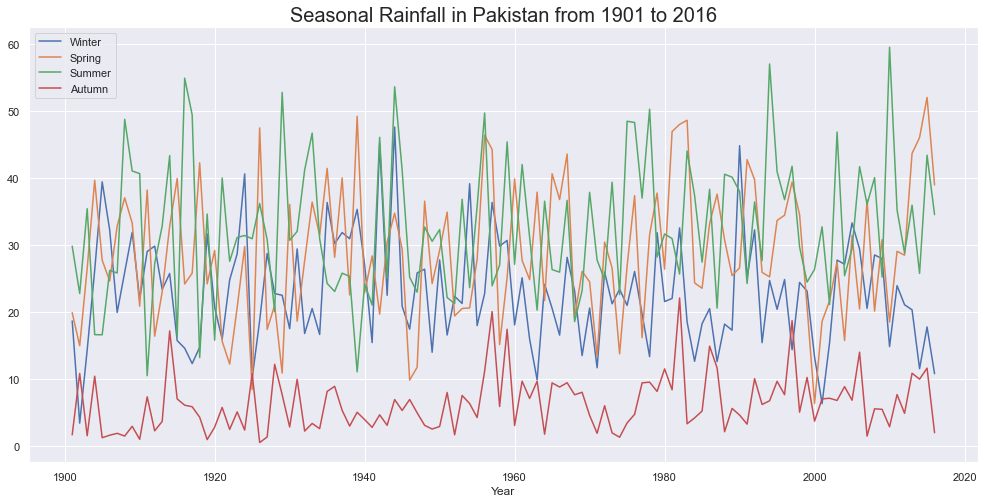

In [9]:
winter=df.query('Month=="December" or Month=="January" or Month=="February"').groupby([df.Year]).mean()['Rainfall']
spring=df.query('Month=="March"or Month=="April"').groupby([df.Year]).mean()['Rainfall']
summer=df.query('Month=="May" or Month=="June" or Month=="July" or Month=="August"or Month=="September"').groupby([df.Year]).mean()['Rainfall']
Autumn=df.query('Month=="October" or Month=="November"').groupby([df.Year]).mean()['Rainfall']
data=pd.DataFrame({ 'Winter': winter, 'Spring': spring,'Summer': summer, 'Autumn': Autumn })
data.plot(figsize=(17,8));
plt.title('Seasonal Rainfall in Pakistan from 1901 to 2016',fontsize=20);



In [9]:
y=data.mean()
x=data.columns
fig = px.bar(x=x,y=y,color=x,title='Season wise Rainfall in Pakistan')
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()

In [10]:
ax=df.groupby([df.index.year]).agg({'Rainfall':sum})
print('The largest amount of rain was recorded in the following years')
ax['Rainfall'].nlargest(5)

The largest amount of rain was recorded in the following years


Date
1944    494.37035
1956    431.99396
1994    423.27579
1942    414.70332
1959    404.21003
Name: Rainfall, dtype: float64

In [ ]:
#LSTM MODEL

In [10]:
#Data preprcessing
dataset = df.drop(columns = ['Month','Year'])
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Converting  an array of values into a dataset matrix. The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period and in our case look back is 1.

In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=12):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


In [12]:


# split into train and test sets
training_size=int(len(dataset)*0.90)
test_size=len(dataset)-training_size
train, test =dataset[0:training_size,:],dataset[training_size:len(dataset),:1]

#reshape into X=t and Y=t+1
look_back =12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: (samples, time steps, features) but Currently, our data is in the form: (samples, features)

In [13]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design and fit our LSTM network.

In [14]:

# create and fit the LSTM network
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,look_back)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=600, batch_size=200, validation_data=(testX, testY), shuffle=False)


Epoch 401/600
7/7 [==============================] - 0s 18ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 402/600
7/7 [==============================] - 0s 19ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 403/600
7/7 [==============================] - 0s 20ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 404/600
7/7 [==============================] - 0s 19ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 405/600
7/7 [==============================] - 0s 18ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 406/600
7/7 [==============================] - 0s 18ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 407/600
7/7 [==============================] - 0s 20ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 408/600
7/7 [==============================] - 0s 18ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 409/600
7/7 [==============================] - 0s 19ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 410/600
7/7 [==============================] - 0s 18ms/step - loss: 0.0130 - val_loss: 0.0123


###  A plot of learning curves 
Train and Validation Learning Curves Showing a Good Fit because The plot of validation loss decreases and has a small gap with the training loss.

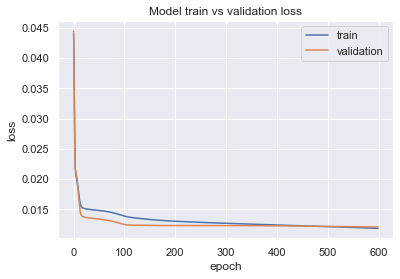

In [16]:

# plot train and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


The model is fit, now we can estimate the performance of the model on the test datasets.

In [17]:

testPredict = model.predict(testX)
# invert predictions
test_Predict = scaler.inverse_transform(testPredict)
test_Y = scaler.inverse_transform([testY])
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(test_Y[0], test_Predict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 16.90 RMSE


In [18]:

data = df.drop(columns = ['Month','Year'])
testindex=data[-(testY.size):]
future_forecast = pd.DataFrame(test_Predict[:,0],index =testindex.index,columns=['Prediction'])
pd.concat([testindex,future_forecast],axis=1).iplot()

#ARIMA MODEL

**ARIMA models work on the following assumptions –**

1. The data series is stationary, which means that the mean and variance should not vary with time.
1. The data provided as input must be a univariate series, since arima uses the past values to predict the future values.

**To identify the nature of data, we will be using the null hypothesis.**

* Ho: It is non-stationary
* H1: It is stationary
We will be considering the null hypothesis that data is not stationary and the alternate hypothesis that data is stationary.



In [18]:
test_result=adfuller(df['Rainfall'])
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df['Rainfall'])


ADF Test Statistic : -6.695889008362767
p-value : 4.000735413148214e-09
#Lags Used : 23
Number of Observations : 1368
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


As we are working on univariate time series and Data is also stationary.So we can use Arima model.

In [19]:
# split into train and test sets
training_size=int(len(df)*0.90)
test_size=len(df)-training_size
train,valid=df.iloc[0:training_size,:],df.iloc[training_size:len(df),:1]
training = train['Rainfall']
validation = valid['Rainfall']

ARIMA has three components – AR (autoregressive term), I (differencing term) and MA (moving average term). 

1. AR term refers to the past values used for forecasting the next value and it represented by p.
1. MA term is used to defines number of past forecast errors used to predict the future values and it represented by q.
1. Order of differencing  specifies the number of times the differencing operation is performed on series to make it stationary and it represented by d.

**I'm using auto arima in which i don't have to select the combination of p, q, d.Because the model select the best combination of these parameters.**

In [21]:
model = auto_arima(training, start_p=0, start_q=0,max_p=3, max_q=3, m=12,start_P=0,start_Q=0,max_P=1,max_Q=1, seasonal=True,d=0, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=11329.894, Time=0.32 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=10964.788, Time=1.54 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=11327.903, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=11318.676, Time=0.28 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=10970.745, Time=1.02 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=10966.573, Time=1.39 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=10966.244, Time=3.01 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=10964.602, Time=1.18 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=11317.821, Time=0.18 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(0,0,2)(1,1,0)[12] intercept   : AIC=10966.477, Time=1.21 sec
 ARIMA(1,0,2)(1,1,0)[12] inte

ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [22]:

future_forecast = model.predict(len(valid))
future_forecast = pd.DataFrame(future_forecast,index =valid.index,columns=['Prediction'])
pd.concat([valid,future_forecast],axis=1).iplot()

In [23]:
testScore = math.sqrt(mean_squared_error(valid,future_forecast))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 16.37 RMSE
